# Food Classifier

### In this project we will be using CNN models to predict the food in images.

In this subset, we will be using "appetizers", which includes 18 classes.

This notebook was run in Google Colab and is best run using GPUs as the data augmentation section takes quite some time to run.

## Importing libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add, Input,
                                     BatchNormalization, MaxPool2D, GlobalAvgPool2D,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims


from PIL import Image
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import datetime
import os

## Reading in the data

In [4]:
# loading in Google Drive to retrieve the dataset(s)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# creating a path variable for the data subset we'll be modeling on
img_path = "/content/drive/My Drive/Capstone/food-11/images/appetizers"
img_size = 299
img_size_tup = (299, 299)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path, 
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='training',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 18000 files belonging to 18 classes.
Using 14400 files for training.


In [6]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

# directory_imgs = "/content/drive/My Drive/Capstone/food-11/validation"

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='validation',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 18000 files belonging to 18 classes.
Using 3600 files for validation.


In [7]:
# looking at our train_data variable to see shape and type
train_data

<BatchDataset shapes: ((None, 299, 299, 3), (None, 18)), types: (tf.float32, tf.float32)>

In [8]:
# creating variable for class names
class_names = test_data.class_names

# creating variable for number of classes
n_classes = len(train_data.class_names)
n_classes, class_names

(18,
 ['beef_carpaccio',
  'beef_tartare',
  'bruschetta',
  'ceviche',
  'cheese_plate',
  'crab_cakes',
  'deviled_eggs',
  'edamame',
  'escargots',
  'fried_calamari',
  'guacamole',
  'gyoza',
  'miso_soup',
  'nachos',
  'samosa',
  'spring_rolls',
  'takoyaki',
  'tuna_tartare'])

# EDA & Preprocessing the Data

In [9]:
# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
for images, labels in train_data.take(1):  # only take first element of dataset
    X_train = images.numpy()
    y_train = labels.numpy()

In [10]:
# doing the same as above for our test_data
for images, labels in test_data.take(1):  # only take first element of dataset
    X_test = images.numpy()
    y_test = labels.numpy()

In [11]:
X_train[0][0][0], y_train[0]

(array([67.81795 , 44.817947, 52.817947], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float32))

In [12]:
# checking the shape of X_train
X_train.shape

(32, 299, 299, 3)

In [13]:
# checking the shape of y_train
y_train.shape

(32, 18)

In [14]:
# resizing our arrays to get the values between 0-1 which will speed up our model output
X_train /= 255
X_test /= 255

X_train[0][0][0]

array([0.26595274, 0.17575666, 0.20712921], dtype=float32)

In [15]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape

# Visualizing the Data

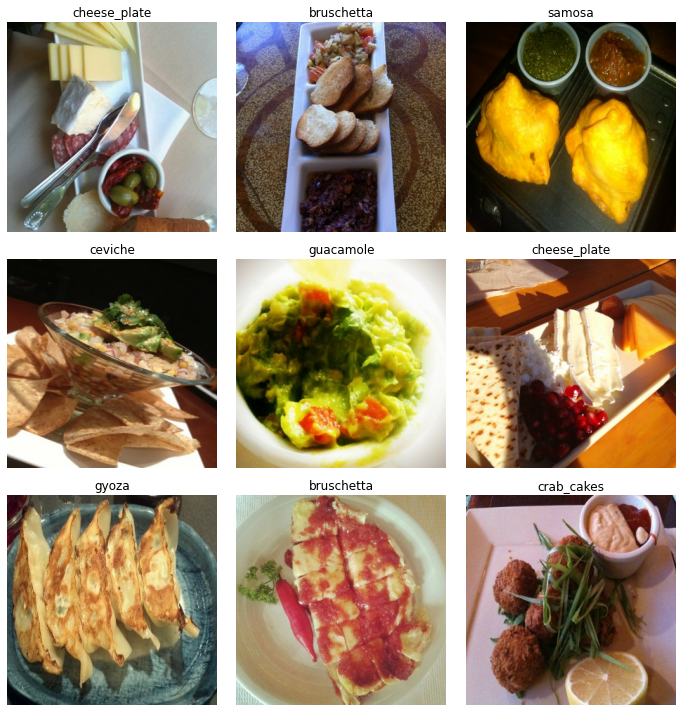

In [16]:
# code from https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")
        plt.tight_layout()

# Predicting on our Data Using Pre-Trained Model

[('n07583066', 'guacamole', 0.95776045),
 ('n07880968', 'burrito', 0.0011282829),
 ('n03786901', 'mortar', 0.0007729902),
 ('n07875152', 'potpie', 0.0005272243),
 ('n07718747', 'artichoke', 0.00030921484)]

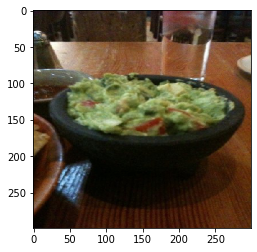

In [17]:
# code from https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras

# instantiating the Xception pre-trained weights model
model = Xception(weights='imagenet')
# our image path to one of our dataset's images
img_path_single = "/content/drive/My Drive/Capstone/food-11/images/appetizers/guacamole/18985.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
# decoding the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=5)[0]

Our pre-trained model Xception (which was also trained on food images as well as other classes) is doing a pretty terrible job predicting our french fries. These pre-trained models will serve as the base for our model to try to get our predictions right.

# Modeling with Neural Nets & Pre-trained Weights

## Modeling with Xception Pretrained Model

In [18]:
# code from https://keras.io/api/optimizers/
# creating a learning rate schedule to be used with our model optimizer
# this will decay the rate of learning over the number of steps given
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7,
    decay_steps=10000,
    decay_rate=0.3)

In [19]:
# code help: https://keras.io/api/applications/
# code help: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

# instantiating pre-trained model
X_model = Xception(weights='imagenet', include_top=False)

# freezing the model layers
for layer in X_model.layers:
    layer.trainable = False

# adding a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# adding a fully-connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
# adding logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=X_model.input, outputs=predictions)

# compiling the model
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=15)

# fitting and running our model
X_results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, callbacks=early_stop, workers=4)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.8775 - accuracy: 0.0625 - val_loss: 2.9409 - val_accuracy: 0.1250
Epoch 2/100
1/1 [==============================] - 0s 300ms/step - loss: 2.5382 - accuracy: 0.2500 - val_loss: 2.8691 - val_accuracy: 0.1250
Epoch 3/100
1/1 [==============================] - 0s 307ms/step - loss: 2.2909 - accuracy: 0.2500 - val_loss: 2.9532 - val_accuracy: 0.1250
Epoch 4/100
1/1 [==============================] - 0s 298ms/step - loss: 2.0937 - accuracy: 0.4062 - val_loss: 2.9882 - val_accuracy: 0.1250
Epoch 5/100
1/1 [==============================] - 0s 297ms/step - loss: 2.2244 - accuracy: 0.2812 - val_loss: 3.0675 - val_accuracy: 0.1562
Epoch 6/100
1/1 [==============================] - 0s 305ms/step - loss: 2.3902 - accuracy: 0.2500 - val_loss: 3.9523 - val_accuracy: 0.1562
Epoch 7/100
1/1 [==============================] - 0s 302ms/step - loss: 2.2493 - accuracy: 0.4375 - val_loss: 3.4394 - val_accuracy: 0.1562
Epoch 8/100
1/1 

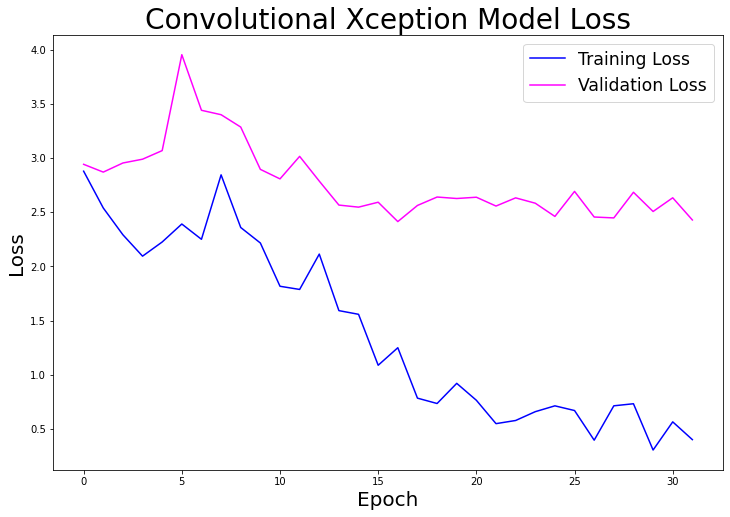

In [20]:
# plotting our loss over epochs for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['loss'], label='Training Loss', color='blue')
plt.plot(X_results.history['val_loss'], label='Validation Loss', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_apps.png', bbox_inches='tight');

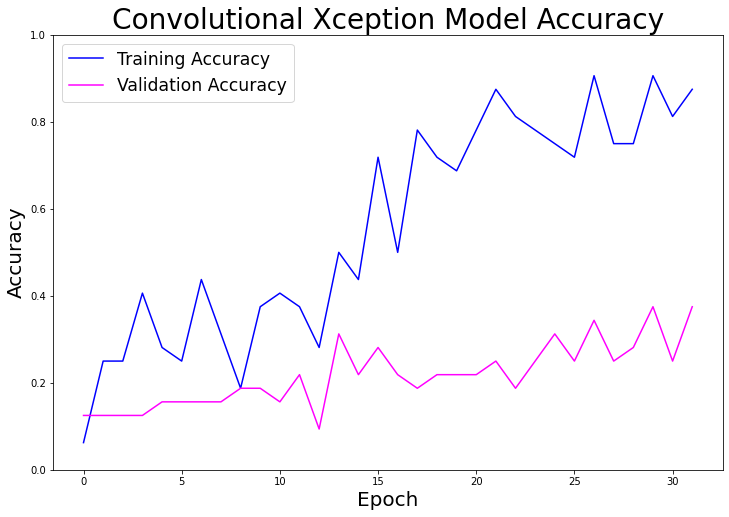

In [21]:
# plotting our accuracy over epochs for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(X_results.history['val_accuracy'], label='Validation Accuracy', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_apps.png', bbox_inches='tight');

In [22]:
# evaluating on test data
X_score = model.evaluate(X_test, y_test, verbose=1)

X_labels = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 1s 1s/step - loss: 2.4275 - accuracy: 0.3750
Xception loss  : 2.4274868965148926
Xception accuracy   : 0.375


** Interpretation **

The Xception pre-trained model isn't doing well on this subset, with 37.5% accuracy on testing data (90% on training).

In [23]:
# saving the model
from tensorflow.keras.models import load_model, clone_model
model.save("/content/drive/My Drive/Capstone/Xception_model_apps.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_apps.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://fd59fa69-d67a-4bfb-ab67-05a169b85168/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [24]:
## code from lesson 9.04
# making predictions on X_test
preds_1 = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df_1 = pd.DataFrame({
    'Label': preds_1,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df_1.to_csv('/content/drive/My Drive/Capstone/X_preds_apps.csv', index=False)

# Testing Our Model on Random Images

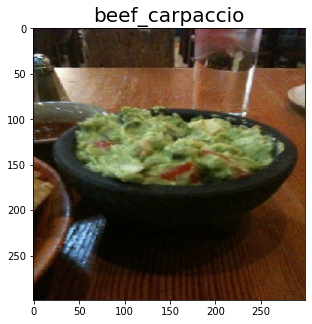

In [25]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# loading the image and preprocessing it for the model to predict it
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);


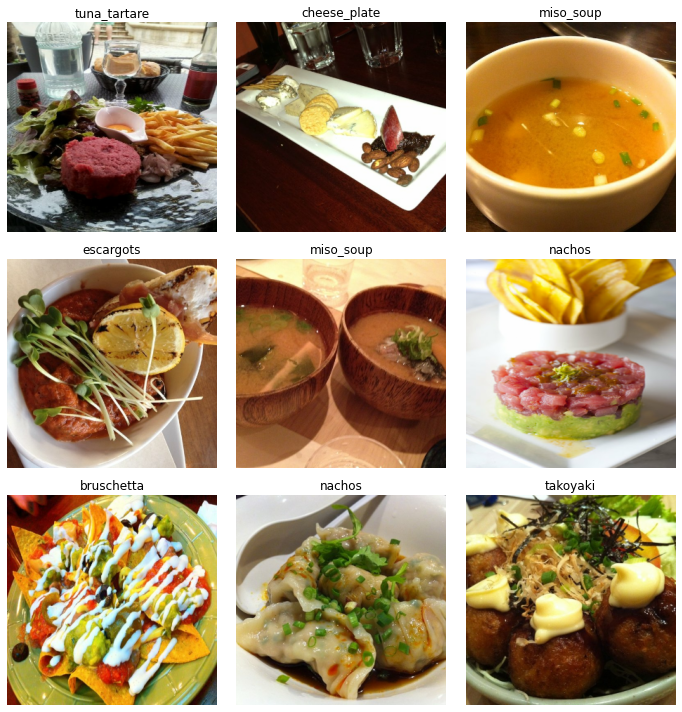

In [26]:
# visualizing a batch of images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

Our Xception model is extremely overfit and doesn't perform well on our test data. Below we will try using data augmentation to add more images for training and testing, which should help our model's loss and scores. Data augmentation is a method of creating new similar images from our existing image dataset in order to supplement our data when there isn't enough to get good model results from.

In [27]:
# https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/Image%20Classification%20with%20Transfer%20Learning.md
# preprocessing our data using data augmentation

# data pre-processing for training
train_datagen =  ImageDataGenerator( 
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)


# generate and store training data
train_generator = train_datagen.flow_from_directory(
    img_path,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32, 
    subset='training',
    )

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    img_path,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32,
    subset='validation')

Found 14400 images belonging to 18 classes.
Found 3600 images belonging to 18 classes.


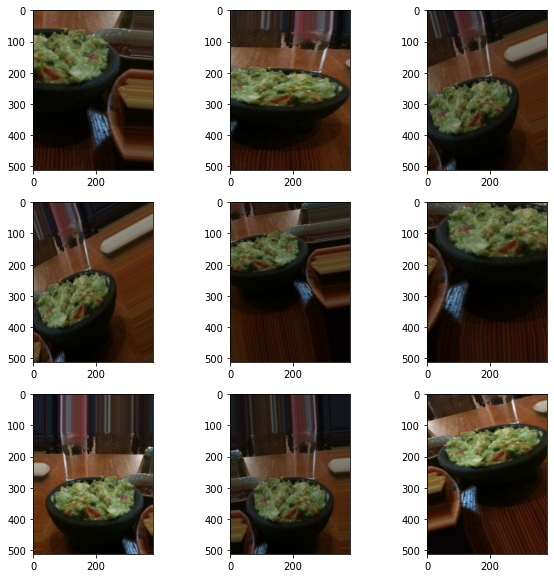

In [28]:
# code help from https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# visualizing our images with data augmentation implemented
plt.figure(figsize=(10, 10))
# load the image
img = load_img(img_path_single)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

data_augmentation = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = data_augmentation.next()
	# plot raw pixel data
	plt.imshow(batch[0])
# show the figure
plt.show()

In [29]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7, 
    decay_steps=10000,
    decay_rate=0.7)

# instantiating the model
X_model = Xception(weights='imagenet', include_top=False)


# adding a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# adding a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# instantiating the model we'll be training
model = Model(inputs=X_model.input, outputs=predictions)
# freezing the layers
for layer in X_model.layers:
    layer.trainable = False
# compiling the model
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=15)

# fitting the model, and logging the results and the training time
now = datetime.datetime.now
t = now()
results_2 = model.fit(
    train_generator,
    epochs=100, 
    steps_per_epoch=140, 
    callbacks=early_stop, 
    workers=8,
    validation_data = validate_generator)
print('Training time: %s' % (now() - t))


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 [==============================] - 322s 3s/step - loss: 2.1378 - accuracy: 0.3723 - val_loss: 1.5834 - val_accuracy: 0.5453
Epoch 2/100
100/100 [==============================] - 184s 2s/step - loss: 1.5827 - accuracy: 0.5238 - val_loss: 1.6725 - val_accuracy: 0.5061
Epoch 3/100
100/100 [==============================] - 159s 1s/step - loss: 1.4121 - accuracy: 0.5675 - val_loss: 1.1582 - val_accuracy: 0.6567
Epoch 4/100
100/100 [==============================] - 156s 1s/step - loss: 1.3080 - accuracy: 0.6130 - val_loss: 1.2232 - val_accuracy: 0.6311
Epoch 5/100
100/100 [==============================] - 156s 1s/step - loss: 1.2779 - accuracy: 0.6159 - val_loss: 1.1184 - val_accuracy: 0.6525
Epoch 6/100
100/100 [==============================] - 155s 1s/step - loss: 1.2183 - accuracy: 0.6363 - val_loss: 1.0911 - val_accuracy: 0.6664
Epoch 7/100
100/100 [==============================] - 173s 2s/step - loss: 1.2102 - accuracy: 0.6381 - val_loss: 1.0348 - val_accuracy: 0.6994
Epoc

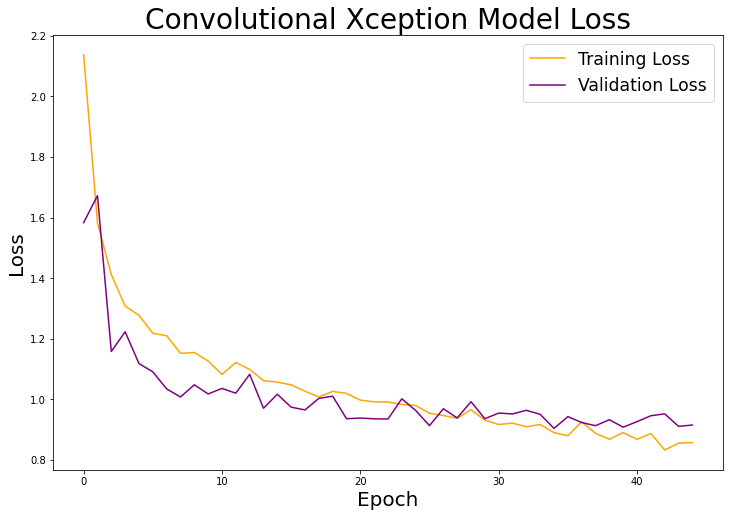

In [30]:
# plotting our loss for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['loss'], label='Training Loss', color='orange')
plt.plot(results_2.history['val_loss'], label='Validation Loss', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.ylim(0, 2.2)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('X_loss_apps_DA.png', bbox_inches='tight');

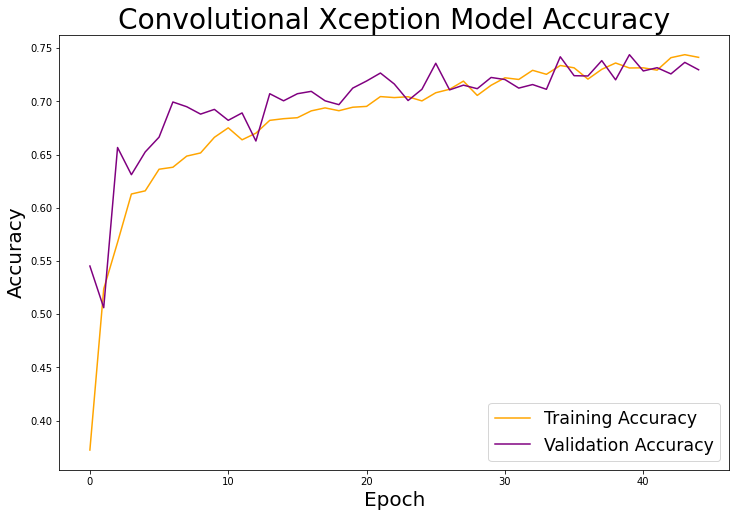

In [31]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(results_2.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 100)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('X_accuracy_apps_DA.png', bbox_inches='tight');

In [32]:
# saving our model weights
model.save("/content/drive/My Drive/Capstone/Xception_model_apps_DA.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_apps_DA.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://f253185d-f980-4800-8147-009e88801057/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [33]:
# evaluating on test data
X_score_DA = model.evaluate(X_test, y_test, verbose=1)

X_labels_DA = model.metrics_names

# comparing our model scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')
print(f'Xception_DA {X_labels_DA[0]}  : {X_score_DA[0]}')
print(f'Xception_DA {X_labels_DA[1]}   : {X_score_DA[1]}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 0.8219 - accuracy: 0.7500
Xception loss  : 2.4274868965148926
Xception accuracy   : 0.375
Xception_DA loss  : 0.8219373226165771
Xception_DA accuracy   : 0.75


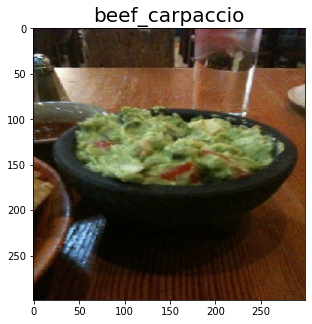

In [34]:
# visualizing one prediction
plt.figure(figsize=(5,5))

# loading the image and preprocessing it for the model to predict it
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

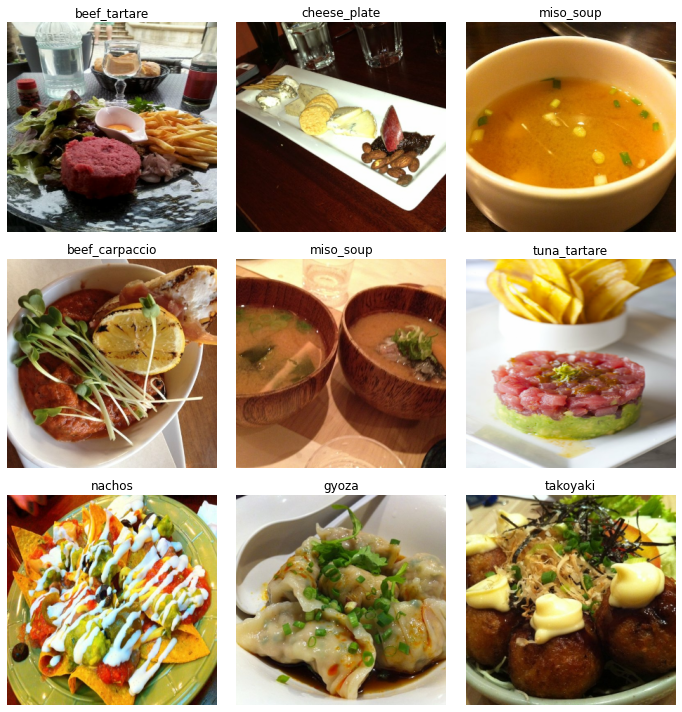

In [35]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

# Conclusions & Recommendations

Our first model perfomed quite poorly and was very overfit. Our second model with data augmentation performed much better but took much more time to run.

More time is needed to try more tricks to improving our model.